<a href="https://colab.research.google.com/github/cooooooky/DL/blob/main/Lab_05_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/Colab\ Notebooks/Lab\ 05-2

[Errno 2] No such file or directory: 'gdrive/MyDrive/Colab Notebooks/Lab 05-2'
/content/gdrive/MyDrive/Colab Notebooks/Lab 05-2


[경로설정방법 참고 블로그](https://codingalone.tistory.com/2)


In [ ]:
!pwd 

/content/gdrive/MyDrive/Colab Notebooks/Lab 05-2


In [ ]:
base_path = '/content/drive/MyDrive/Colab Notebooks/Lab 05-2/'
# df_train = pd.read_csv(base_path  +  'train.txt')

## 1. Settings

#### 1) Important required Libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

#### 2) Hyperparameter

In [ ]:
batch_size = 16 # 64 # 1
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer의 노드 수
dropratio = 0.5

imgsize = 150

## 2. Data Loader

#### 트레이닝 데이터

In [ ]:
img_dir = "IIC/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                           transforms.CenterCrop(imgsize*2),
                                                           transforms.RandomCrop(imgsize),
                                                           transforms.RandomHorizontalFlip(),

                                                           transforms.Resize(imgsize),
                                                           transforms.ToTensor()  
                                                           ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

14034


In [ ]:
img_dir = "IIC/val"
val_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                           transforms.CenterCrop(size=imgsize),
                                                           transforms.Resize(imgsize),
                                                           transforms.ToTensor()  
                                                           ]))
print(val_data.__len__())

val_batch = data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

3000


In [ ]:
img_dir = "IIC/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                           transforms.CenterCrop(size=imgsize),
                                                           transforms.Resize(imgsize),
                                                           transforms.ToTensor()  
                                                           ]))
print(val_data.__len__())

test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

3000


In [ ]:
nclass = len(train_data.classes)
print("# of classes : %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Val: %d, Test: %d" %(train_data.__len__(), val_data.__len__(), test_data.__len__() ) )

print(len(train_batch))
#for imgs, labels in train_batch:  # 모든 batch(878개)에 대해
#  for j in range(len(imgs)):      # batch 내의 16개의 이미지를 출력
#    img = transforms.ToPILImage()(imgs[j])
#    plt.title("labels: %d" %labels[j])
#    plt.imshow(img)
#    plt.show()

# of classes : 6
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
14034
Training: 14034, Val: 3000, Test: 707
878


In [ ]:
print(train_data.classes)
print(val_data.classes)
print(test_data.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 3. Model

### 1) Pretrained VGG Model

In [ ]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt = 0
#ffor i in vgg.named_children():  # 위 두 줄과 같은 출력
#  print("yhk[%d]" %cnt)
#  print(i)
#  cnt = cnt+1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [ ]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
  def __init__(self):
    super(MyVGG, self).__init__()
    # [0]: features, [1]: classifier(fc)
    self.layer0 = nn.Sequential(*list(vgg.children())[0])

    self.layer1 = nn.Sequential(
        nn.Linear(8*base_dim*fsize*fsize, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, n_node),
        nn.BatchNorm1d(n_node),
        nn.ReLU(),
        nn.Dropout2d(dropratio),

        nn.Linear(n_node, nclass),
    )

      #weight initialization
    for m in self.layer1.modules():
      print(m)
      if isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight.data) #ReLU 일 때
        m.bias.data.fill_(0)
      if isinstance(m, nn.Linear):
        init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)

  def forward(self, x):
    out = self.layer0(x)
    out = out.view(out.size(0), -1)
    out = self.layer1(out)
    return out

### 3) Model on GPU

In [ ]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
  params.required_grad = False

for params in model.layer1.parameters():
  params.required_grad = True

for name in model.children():
  print(name)

Sequential(
  (0): Linear(in_features=8192, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout2d(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout2d(p=0.5, inplace=False)
  (8): Linear(in_features=1024, out_features=6, bias=True)
)
Linear(in_features=8192, out_features=1024, bias=True)
BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
Linear(in_features=1024, out_features=1024, bias=True)
BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout2d(p=0.5, inplace=False)
Linear(in_features=1024, out_features=6, bias=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

## 5. Train

In [ ]:
import utils

total_time = 0
disp_step = 2

to_train = True
if(to_train==False):
  netname = './nets/ICC_vgg19_01.pkl'
  model = torch.load(netname)
else:
  print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
  model.eval()
  train_corr = utils.ComputeCorr(train_batch, model)
  val_corr = utils.ComputeCorr(val_batch, model)
  test_corr = utils.ComputeCorr(test_batch, model)
  print("Correct of train: %.2f, val: %.2f, test: %.2f" %(train_corr, val_corr, test_corr))
  model.train()

  netname = 'nets/IIC_vgg19'

# graph 그리기
  x_epoch = []
  y_train_err = []
  y_val_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100-train_corr)
  y_val_err.append(100-val_corr)
  y_test_err.append(100-test_corr)

# 학습을 재시작한다면
#   netname = '../nets/IIC_pre_vgg19.pkl'
#   model = torch.load(netname)
# 파라미터 학습 여부 결정
#   for params in model.layer0.parameters():
#     params.required_grad = False
#   for params in model.layer1.parameters():
#     params.required_grad = True
#   for i in range(34, epoch):

# 재시작하지 않는다면
  for i in range(epoch):
    start_time = time.time()
    print("%d.." %i)
    for img, label in train_batch:
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()

    end_time = time.time()
    duration = end_time - start_time
    total_time += duration
    if(i%disp_step==0) or (i==epoch-1):
      torch.save(model, netname+'_%d.pkl' %i, )
      print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy() ) )
      
      model.eval()
      train_corr = utils.ComputeCorr(train_batch, model)
      val_corr = utils.ComputeCorr(val_batch, model)
      test_corr = utils.ComputeCorr(test_batch, model)
      print("Correct of train: %.2f, val: %.2f, test: %.2f" %(train_corr, val_corr, test_corr))
      model.train()
      print("time: %.2f sec.." %(total_time))

      x_epoch.append(i+1)   # 그래프 그리기
      y_train_err.append(100-train_corr)
      y_val_err.append(100-val_corr)
      y_test_err.append(100-test_corr)

  print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Correct of train: 76.93, val: 77.70, test: 73.13
0..

[0/20] loss: 1.794, 
Correct of train: 74.97, val: 80.13, test: 76.24
time: 73.37 sec..
1..
2..

[2/20] loss: 1.766, 
Correct of train: 78.97, val: 83.47, test: 78.22
time: 219.92 sec..
3..
4..

[4/20] loss: 1.768, 
Correct of train: 80.82, val: 87.30, test: 81.47
time: 366.60 sec..
5..
6..

[6/20] loss: 1.396, 
Correct of train: 81.99, val: 87.07, test: 78.78
time: 513.15 sec..
7..
8..

[8/20] loss: 1.810, 
Correct of train: 80.80, val: 82.60, test: 74.54
time: 659.86 sec..
9..
10..

[10/20] loss: 1.190, 
Correct of train: 80.96, val: 83.50, test: 77.51
time: 806.45 sec..
11..
12..

[12/20] loss: 0.872, 
Correct of train: 82.59, val: 85.37, test: 79.07
time: 953.17 sec..
13..
14..

[14/20] loss: 1.807, 
Correct of train: 82.39, val: 88.27, test: 81.61
time: 1099.77 sec..
15..
16..

[16/20] loss: 0.895, 
Correct of train: 80.38, val: 83.80, test: 77.79
time: 1246.33 sec..
17..
18..

[18/20] loss: 1.774, 
Correct of train: 82.15, val

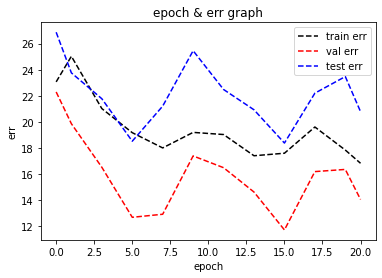

In [ ]:
# epoch-error curve
if(to_train):
  plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
  plt.plot(x_epoch, y_val_err, color='red', label='val err', linestyle='--')
  plt.plot(x_epoch, y_test_err, color='blue', label='test err', linestyle='--')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc="upper right")
  plt.show()

## 6. Evaluation for val & test data

In [73]:
from sklearn.metrics import confusion_matrix
import itertools

In [80]:
def my_softmax(arr):
    sum = 0.0
    for i in range(len(arr)):
        sum = sum + np.exp(arr[i])
    
    for i in range(len(arr)):
        arr[i] = np.exp(arr[i]) / sum
    return arr

def ComputePredProb(i_batch, i_model, i_classes, i_batch_size=32):
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs) 
        
    nclass = len(i_classes)
    
    # 2. pred, true
    pred_1d = np.ndarray(n, dtype=int)    # 모든 n개 영상에 대한 prediction
    label_1d = np.ndarray(n, dtype=int)   # 모든 n개 영상에 대한 true label
    probability_1d = np.ndarray(n, dtype=float)
    probability_total_2d = np.ndarray((n, nclass), dtype=float)  # 모든 n개 영상에 대한 모든 클래스의 probability (n x nclass)
    for i, [imgs, labels] in enumerate(i_batch):
        torch.no_grad()
        x = Variable(imgs).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()
        
        output = i_model(x)
        _, output_index = torch.max(output, 1)
    
        # 1) pred
        output_index_cpu = (output_index.data.cpu()).numpy()  #cpu()
        y_cpu = (y_.data.cpu()).numpy()  #cpu()
        
        size = len(x)
#         s = (i*i_batch_size)
#         e = s + size    
        for k in range(size):
            pred_1d[i*i_batch_size + k] = int(output_index_cpu[k])
            label_1d[i*i_batch_size + k] = int(y_cpu[k])
        
        # 2) probability
        prob_arr = (output.cpu()).data.numpy()
        for k in range(size):
            prob = my_softmax(prob_arr[k])
            idx = pred_1d[i*i_batch_size + k]
            probability_1d[i*i_batch_size + k] = prob[idx]
                                      
            #print(prob.size())
            probability_total_2d[i*i_batch_size + k, :] = prob  # (n x nclass)                                      
        
    return pred_1d, label_1d, probability_1d, probability_total_2d

def EvaluateClassifier(i_batch, i_model, i_classes, i_batch_size=32):
    # --- 1. Confusion matrix 그리기 ---
    # 1) pred, true 배열 구하기
    # 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)    
    
    pred_1d, label_1d, prob_1d, prob_2d = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)
    
    # 2) confusion matrix 계산
    #print("size of pred: %d, true: %d" %(len(pred_1d), len(label_1d)))
    cnf_mat = confusion_matrix(label_1d, pred_1d)
    #del pred_1d, label_1d

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, title='Confusion matrix, without normalization')
    plt.show()

    # --- 2. Accr, F1, Precision, Recall ---
    matric4classifer(cnf_mat, i_classes)
    
    # --- 3. mAP(mean average precision ---
    # aps: 각 클래스의 AP
    # o_mAP: 모든 AP의 평균
    o_mAP, aps = mAP(prob_2d, label_1d, i_classes)
    
    # --- 4. imAP(image mean average precision) ---
    o_imAP, iaps = imAP(prob_2d, label_1d)
    
    return pred_1d, label_1d, prob_1d

def matric4classifer(cm, classes):
    n = len(classes)
    acc = np.ndarray((n), dtype=float)
    pre = np.ndarray((n), dtype=float)
    rec = np.ndarray((n), dtype=float)
    f1 = np.ndarray((n), dtype=float)

    '''
    TP: cm[i, i]
    FP: cm[:i-1, i] + cm[i+1:, i]
    FN: cm[i, :i-1] + cm[i, i+1:]
    TN: cm[:i-1, :i-1] + cm[i+1:, i+1:]
    '''
    print("\t acc  |\t pre  |\t rec  |\t f1")
    # 각 클래스마다
    for i, c in enumerate(classes):
        # 1. Accuracy = (TP+TN) / (TP+FP+FN+TN)
        if (i-1<0):
            tn1 = 0
        else:
            tn1 = np.sum(cm[:i, :i])   # [:i] '0 ~ i-1' 까지
            
        if (i+1>=n):
            tn2 = 0
        else:
            tn2 = np.sum(cm[i+1:, i+1:])  # [i:] 'i~끝' 까지
            
        acc[i] = float(cm[i, i] + tn1 + tn2) / float(np.sum(cm[:, :]))
        
        # 2. Precision = TP / (TP+FP)
        pre[i] = float(cm[i, i]) / float(np.sum(cm[:, i]))
        # 3. Recall = TP / (TP+FN)
        rec[i] = float(cm[i, i]) / float(np.sum(cm[i, :]))
        # 4. F1 Score = 2 * (precision*recall) / (precision+recall)
        if (float(pre[i] + rec[i])==0):
            f1[i] = 0.0
        else:
            f1[i] = 2.0 * float(pre[i] * rec[i]) / float(pre[i] + rec[i])
        
        print(" %s: %.2f |\t %.2f |\t %.2f |\t %.2f" % (c, acc[i], pre[i], rec[i], f1[i]))
    
    # total matric
    total_acc = np.average(acc)
    total_pre = np.average(pre)
    total_rec = np.average(rec)
    total_f1 = np.average(f1)

    print("*accuracy: %.2f, precision: %.2f, recall: %.2f, *f1 score: %.2f" %(total_acc, total_pre, total_rec, total_f1))
    
    del acc, pre, rec, f1

def GetDelta(i_true, i_classidx):
    # delta: indicator (n). 
    delta = np.zeros(len(i_true))
    for i, label in enumerate(i_true):
        if label==i_classidx:
            delta[i] = 1
    return delta

def P(i_delta, k):
    n = len(i_delta)
    cnt = 0
    for i in range(0, k+1):
        if i_delta[i]==1:
            cnt += 1
    return (float)(cnt) / (float)(k+1)

def AP(i_prob, i_true, i_classidx):
    n = len(i_true)  # # of data
    
    # 1. 분모: delta 합
    # delta: indicator (n). 
    delta = GetDelta(i_true, i_classidx)
    
    # 2. 분자: P@j(i) * delta_i(j) 의 합
    #   0) prob[:, i]에 따라 내림차순 정렬   
    prob, true, delta = zip(*sorted(zip(i_prob[:, i_classidx], i_true, delta), reverse=True))  # 정렬된 prob, true, delta. (n)
        
    #   1) 합 구하기
    res = 0.0
    for j in range(n):
        res += P(delta, j) * delta[j]
        
    div = sum(delta)
    if div==0:
        res = 0.0
    else:
        res = res/div
    return res

def mAP(i_prob, i_true, i_classes):
    ap=[]
    for i in range(len(i_classes)):
        ap.append( AP(i_prob, i_true, i) )  # 각 클래스의 AP
    o_mAP = np.mean(ap)  # 모든 AP의 평균
    
    # 출력
    print("[AP]"),
    for i,c in enumerate(i_classes):
        print("%s: %.2f" %(c, ap[i])),
    print("\n[mAP] %.3f" %o_mAP)
    return o_mAP, ap

def iAP(i_prob, i_true):
    nclass = len(i_prob)
    # 0. delta: true index 만 1이고, 나머지는 0 인 자료 얻기 (nclass)
    delta = np.zeros(nclass)  # (nclass)
    delta[i_true] = 1
    
    # 1. i_prob-> i_prob 에 따라 정렬(내림차순) 
    prob, delta = zip(*sorted(zip(i_prob, delta), reverse=True))
    
    # 2. k=0 to nclass: 
    for k in range(nclass):
        if delta[k]==1:
            return (nclass-k-0.0) / nclass
            #return 1.0 / (k + 1.0)

def imAP(i_prob, i_true):
    n = len(i_prob)
    
    iap=[]
    for i in range(n):
        iap.append( iAP(i_prob[i], i_true[i]) )  # 각 이미지의 AP
    o_imAP = np.mean(iap)
    
    # 출력
    print("[miAP] %.3f" %o_imAP)
    return o_imAP, iap

def plot_confusion_matrix(cm, classes, 
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    #print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),   # 반올림
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


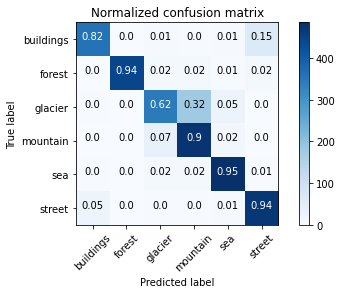

Confusion matrix, without normalization


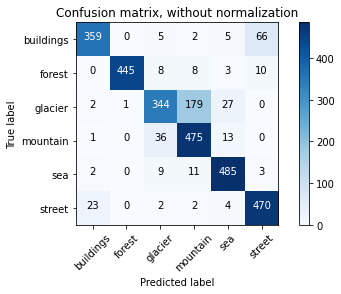

	 acc  |	 pre  |	 rec  |	 f1
 buildings: 0.96 |	 0.93 |	 0.82 |	 0.87
 forest: 0.95 |	 1.00 |	 0.94 |	 0.97
 glacier: 0.87 |	 0.85 |	 0.62 |	 0.72
 mountain: 0.87 |	 0.70 |	 0.90 |	 0.79
 sea: 0.94 |	 0.90 |	 0.95 |	 0.93
 street: 0.96 |	 0.86 |	 0.94 |	 0.90
*accuracy: 0.93, precision: 0.87, recall: 0.86, *f1 score: 0.86
[AP]
buildings: 0.94
forest: 1.00
glacier: 0.87
mountain: 0.85
sea: 0.98
street: 0.96

[mAP] 0.931
[miAP] 0.972


(array([0, 0, 0, ..., 5, 0, 5]),
 array([0, 0, 0, ..., 5, 5, 5]),
 array([0.76591843, 0.43409613, 0.76147968, ..., 0.3869001 , 0.33848971,
        0.7379846 ]))

In [81]:
model.eval()
EvaluateClassifier(val_batch, model, val_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Normalized confusion matrix


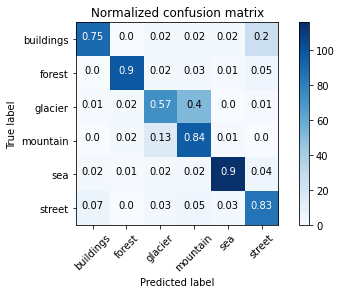

Confusion matrix, without normalization


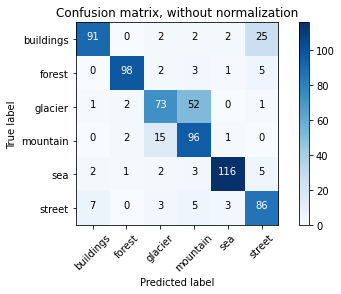

	 acc  |	 pre  |	 rec  |	 f1
 buildings: 0.94 |	 0.90 |	 0.75 |	 0.82
 forest: 0.92 |	 0.95 |	 0.90 |	 0.92
 glacier: 0.82 |	 0.75 |	 0.57 |	 0.65
 mountain: 0.81 |	 0.60 |	 0.84 |	 0.70
 sea: 0.91 |	 0.94 |	 0.90 |	 0.92
 street: 0.92 |	 0.70 |	 0.83 |	 0.76
*accuracy: 0.89, precision: 0.81, recall: 0.80, *f1 score: 0.79
[AP]
buildings: 0.89
forest: 0.95
glacier: 0.81
mountain: 0.70
sea: 0.92
street: 0.72

[mAP] 0.833
[miAP] 0.943


In [83]:
model.eval()
_, _, _ = EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Category: buildings
 True predicted images/total buildings category: 359 / 437
Predicted probability:
[0.76591843 0.00910722 0.08043072 0.02731977 0.07417227 0.0430516 ]


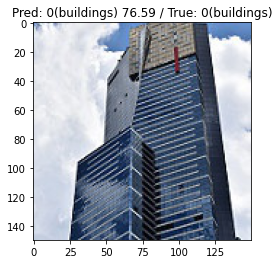

Predicted probability:
[0.43409613 0.06480953 0.11902218 0.13478948 0.09620683 0.15107584]


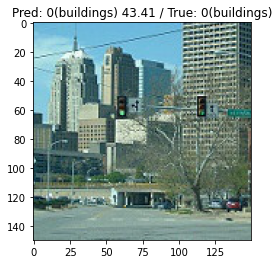

 False predicted images/total buildings category: 78 / 437
Predicted probability:
[0.3051853  0.09566244 0.07693006 0.07976401 0.11051441 0.3319438 ]


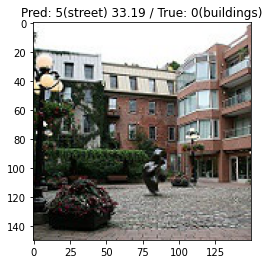

Predicted probability:
[0.37386745 0.03087767 0.11245456 0.01759909 0.05219371 0.4130075 ]


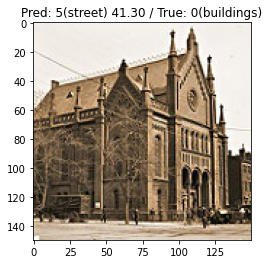

Category: forest
 True predicted images/total forest category: 445 / 474
Predicted probability:
[0.03171604 0.43706977 0.22325553 0.10971398 0.06187304 0.13637164]


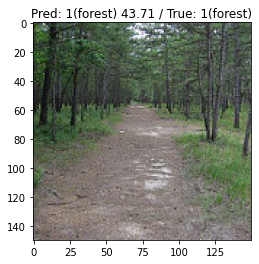

Predicted probability:
[0.04985034 0.45958373 0.13413255 0.09244933 0.01447478 0.24950927]


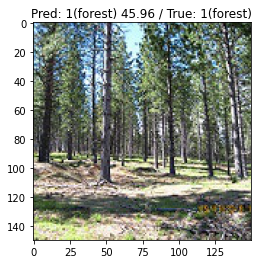

 False predicted images/total forest category: 29 / 474
Predicted probability:
[0.09473771 0.07915015 0.1195434  0.49006376 0.05207423 0.16443078]


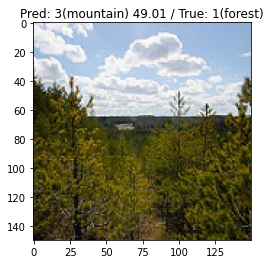

Predicted probability:
[0.07749074 0.22719027 0.16543308 0.26563922 0.16354933 0.10069736]


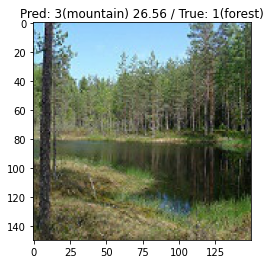

Category: glacier
 True predicted images/total glacier category: 344 / 553
Predicted probability:
[0.02356717 0.04354198 0.7306667  0.13286386 0.03484856 0.03451172]


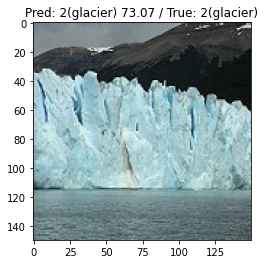

Predicted probability:
[0.02402711 0.01234717 0.41444907 0.3290426  0.1817597  0.03837432]


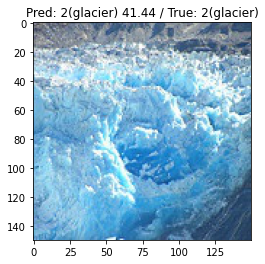

 False predicted images/total glacier category: 209 / 553
Predicted probability:
[0.01113625 0.0088389  0.359995   0.5288575  0.03369445 0.05747785]


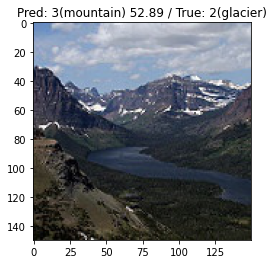

Predicted probability:
[0.00745743 0.00763111 0.43309054 0.5034924  0.0280532  0.02027533]


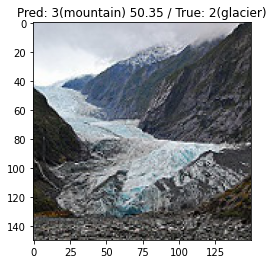

Category: mountain
 True predicted images/total mountain category: 475 / 525
Predicted probability:
[0.02500925 0.02164412 0.2854578  0.46887776 0.14595985 0.05305121]


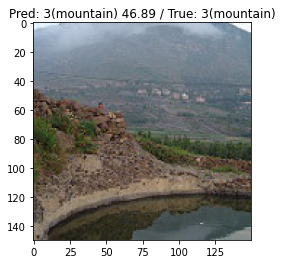

Predicted probability:
[0.05124665 0.0410551  0.14801069 0.5199778  0.17529908 0.06441068]


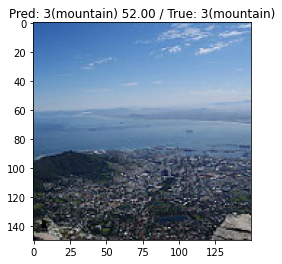

 False predicted images/total mountain category: 50 / 525
Predicted probability:
[0.01683739 0.05987766 0.40180913 0.3938957  0.08297576 0.04460439]


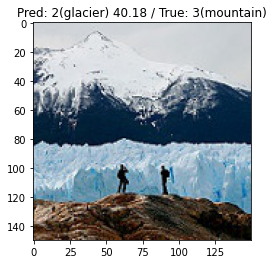

Predicted probability:
[0.0203809  0.01129595 0.29497007 0.23012336 0.34793586 0.09529389]


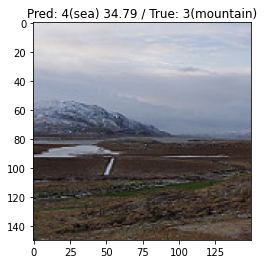

Category: sea
 True predicted images/total sea category: 485 / 510
Predicted probability:
[0.09138764 0.0047865  0.08605264 0.05077656 0.7194282  0.04756847]


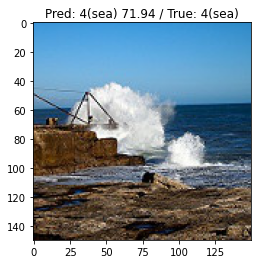

Predicted probability:
[0.08021645 0.11833669 0.13568899 0.15285599 0.42403036 0.0888715 ]


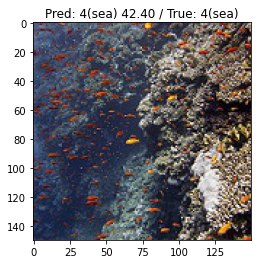

 False predicted images/total sea category: 25 / 510
Predicted probability:
[0.39359164 0.12916183 0.05602898 0.02198342 0.24348815 0.155746  ]


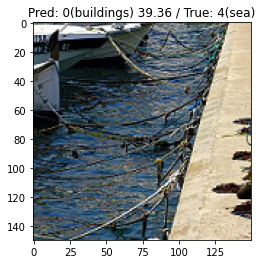

Predicted probability:
[0.19749792 0.01715087 0.17069317 0.12542687 0.1853392  0.30389196]


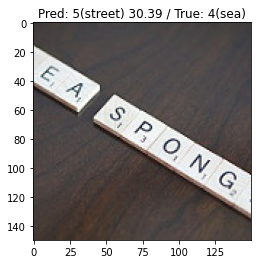

Category: street
 True predicted images/total street category: 470 / 501
Predicted probability:
[0.23879965 0.01497043 0.06290214 0.03786842 0.03331101 0.61214834]


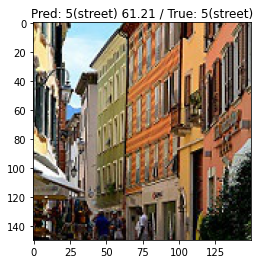

Predicted probability:
[0.25976714 0.01165944 0.1970328  0.05608365 0.0848247  0.3906323 ]


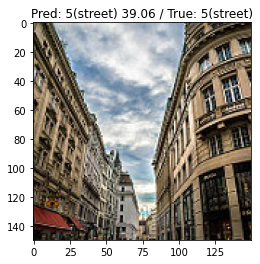

 False predicted images/total street category: 31 / 501
Predicted probability:
[0.36742678 0.01486686 0.1241682  0.06210381 0.10026373 0.33117062]


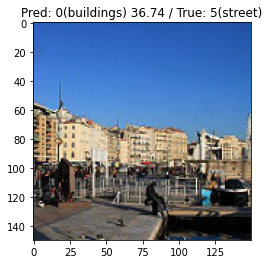

Predicted probability:
[0.58298254 0.0096898  0.04021359 0.03563523 0.07693235 0.2545465 ]


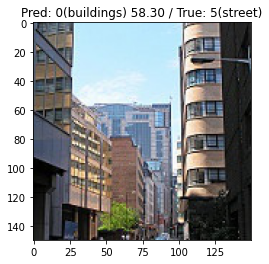

In [ ]:
utils.VisTFPred(val_batch, model, test_data.classes, batch_size, i_n=2)